# Demystifying Variational Inference

## PyMCon 2020 - Oct 31

### Bayes Formula

$$
P\left (\theta | D\right ) = \frac{P\left (D|\theta\right ) * P\left (\theta\right )}{P\left (D\right )}
$$

$\theta$ = Parameters of the model

$P\left (\theta\right )$ = Prior Distribution over the parameters

$P\left (D|\theta\right )$ = Likelihood of the data

$P\left (D\right )$ = Probability of Data. This term is calculated by marginalising out the effect of parameters.

$$
P\left (D\right ) = \int P\left (D|\theta\right ) P\left (\theta\right ) d\left (\theta\right )
$$

So, the Bayes formula becomes -

$$
P\left (\theta | D\right ) = \frac{P\left (D|\theta\right ) * P\left (\theta\right )}{\int P\left (D|\theta\right ) P\left (\theta\right ) d\left (\theta\right )}
$$

## What about MCMC?
* A sampling algorithm to compute posterior.
* We can get exact posterior if we sample for long enough.
* Can we go better in terms of time complexity and generate similar results.

## Variational Inference

In [1]:
import arviz as az
import functools
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import prefer_static

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
plt.style.use('arviz-darkgrid')

dtype = tf.float32
tfb = tfp.bijectors
tfd = tfp.distributions

In [3]:
# Generating data
mu = 12
sigma = 2.2
data = np.random.normal(mu, sigma, 1000)

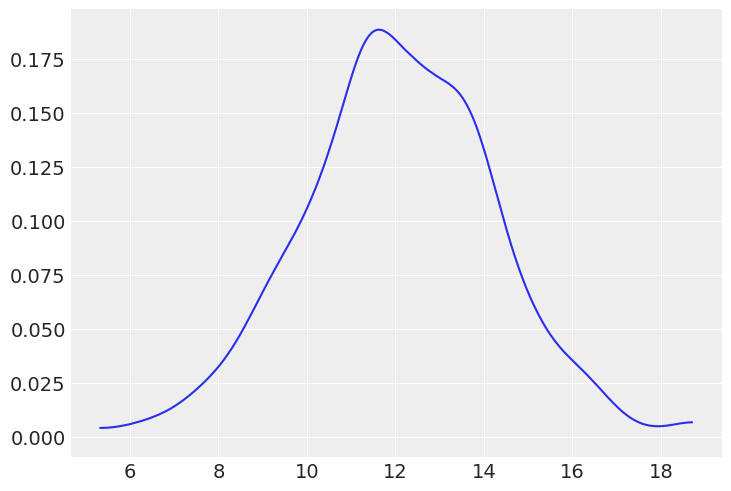

In [4]:
az.plot_kde(data);

In [5]:
# Defining the model
model = tfd.JointDistributionSequential([
    # sigma_prior
    tfd.Exponential(1.),

    # mu_prior
    tfd.Normal(loc=0., scale=1.),

    # likelihood
    lambda mu, sigma: tfd.Normal(loc=mu, scale=sigma, name="ll")
])

In [6]:
print(model.resolve_graph())

(('sigma', ()), ('mu', ()), ('ll', ('mu', 'sigma')))


In [7]:
# Let's generate joint log probability
def joint_log_prob(*samples):
    log_prob_parts = model.log_prob_parts(samples + (data,))
    return sum(map(tf.reduce_sum, log_prob_parts))

In [8]:
contraining_bijectors = [
  tfb.Exp(),
  tfb.Identity()
]

def make_transformed_log_prob(joint_log_prob, contraining_bijectors):

    def transformed_log_prob(samples):
        constrained_samples = list()
        for bij, sample in zip(contraining_bijectors, samples):
            constrained_samples.append(bij.forward(sample))

        tlp = joint_log_prob(*constrained_samples)
        ldj = [
            bij.forward_log_det_jacobian(s, event_ndims=bij.forward_min_event_ndims)
            for bij, s in zip(contraining_bijectors, samples)
        ]

        return tlp + sum(map(tf.reduce_sum, ldj))
    return transformed_log_prob


transformed_log_prob = make_transformed_log_prob(joint_log_prob, contraining_bijectors)

In [9]:
def vectorized_log_prob(logp):
    def vectorize_logpfn(*samples):
        return tf.vectorized_map(lambda sample: logp(*sample), samples)
    return vectorize_logpfn

target_log_prob = vectorized_log_prob(transformed_log_prob)

In [10]:
def build_mf_advi():
    """Build Mean Field posterior assuming all parameters are normally distributed."""
    parameters = model.sample(1)
    parameters.pop()
    dists = []
    for i, parameter in enumerate(parameters):
        shape = parameter[0].shape
        loc = tf.Variable(
            tf.random.normal(shape, dtype=dtype),
            name=f'meanfield_{i}_loc',
            dtype=dtype
        )
        scale = tfp.util.TransformedVariable(
            tf.fill(shape, value=tf.constant(0.02, dtype=dtype)),
            tfb.Softplus(),  # For positive values of scale
            name=f'meanfield_{i}_scale'
        )

        approx_parameter = tfd.Normal(loc=loc, scale=scale)
        dists.append(approx_parameter)
    return tfd.JointDistributionSequential(dists)

meanfield_advi = build_mf_advi()

In [11]:
def variational_loss(target_log_prob, approximating_posterior, sample_size):
    def monte_carlo_expection():
        samples = approximating_posterior.sample(sample_size)
        samples = approximating_posterior.log_prob(samples) - target_log_prob(samples)
        return tf.reduce_mean(samples, axis=0)  # Monte carlo expectation
    
    return monte_carlo_expection

In [12]:
def make_optimizer_function(loss_fn, opt):

    @tf.function(autograph=False)
    def optimizer_fn():
        with tf.GradientTape() as tape:
            loss = loss_fn()

        watched_variables = tape.watched_variables()
        grads = tape.gradient(loss, watched_variables)
        train_op = opt.apply_gradients(zip(grads, watched_variables))
        return loss
    
    return optimizer_fn

In [13]:
def training_body(optimizer_fn):

    def loop_body(step, traced_loss):
        loss = optimizer_fn()
        traced_loss = traced_loss.write(step, loss)
        return [step+1, traced_loss]
    
    return loop_body

In [14]:
def fit(
    target_log_prob,
    approximating_posterior,
    num_steps,
    sample_size,
    opt
):
    loss_fn = variational_loss(target_log_prob, approximating_posterior, sample_size)
    optimizer_fn = make_optimizer_function(loss_fn, opt)

    traced_loss = tf.TensorArray(
        dtype=tf.float32,
        size=num_steps,
        clear_after_read=False,
    )

    _, traced_loss = tf.while_loop(
        cond=lambda *x: True,
        body=training_body(optimizer_fn),
        loop_vars=[0, traced_loss],
        parallel_iterations=1,
        maximum_iterations=num_steps - 1
    )
    return traced_loss

In [15]:
opt = pm.updates.adam()
traced_loss = fit(target_log_prob, meanfield_advi, 30_000, 2, opt)

In [16]:
meanfield_advi.mean()

[<tf.Tensor: shape=(), dtype=float32, numpy=0.7634733>,
 <tf.Tensor: shape=(), dtype=float32, numpy=11.995911>]

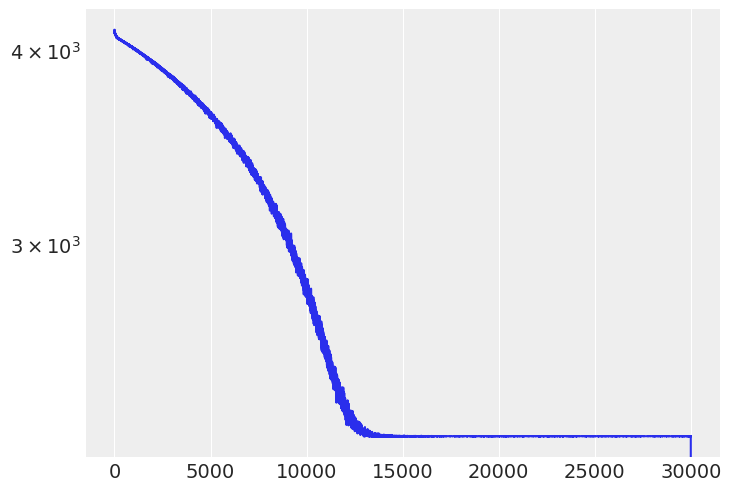

In [17]:
plt.plot(traced_loss.stack().numpy())
plt.yscale('log')

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy                  1.18.5
arviz                  0.10.0
tensorflow             2.4.0-dev20200913
pymc4                  4.0a2
tensorflow_probability 0.11.1
last updated: Wed Oct 07 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
